In [17]:
import os
import pickle
import textwrap
from os.path import dirname, exists, join
import numpy as np
import torch
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import distributions
import matplotlib.pyplot as plt

##Load and visualize shapes data

In [6]:
fname="/content/shapes.pkl"
with open(fname, "rb") as f:
  data = pickle.load(f)
train_data, test_data = data["train"], data["test"]
train_data = (train_data > 127.5).astype("uint8")
test_data = (test_data > 127.5).astype("uint8")

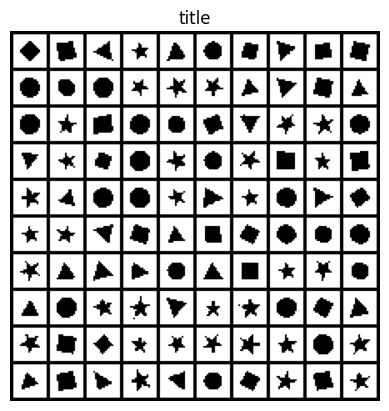

In [7]:
idxs = np.random.choice(len(train_data), replace=False, size=(100,))
images = train_data[idxs].astype("float32") / 1 * 255
def show_sample(images):
  samples = (torch.FloatTensor(images) / 255).permute(0, 3, 1, 2)
  grid_img = make_grid(samples, nrow=10)
  plt.figure()
  plt.title("title")
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis("off")
show_sample(images)

## Model

### Causial attention

In [8]:
def _get_causal_mask(size, mask_center):
    """Generates causal masks for attention weights."""
    return torch.tril(torch.ones((size, size)), diagonal=-int(mask_center))

class CausalAttention(nn.Module):
  def __init__(
      self,
      in_channels,
      n_heads=1,
      embed_channels=None,
      out_channels=None,
      mask_center=False,
      extra_input_channels=0
  ):

    super().__init__()
    self._n_heads=n_heads
    self._embed_channels= embed_channels or in_channels
    self._out_channels=out_channels or in_channels
    self._mask_center=mask_center

    self._q=nn.Conv2d(
        in_channels=in_channels,out_channels=self._embed_channels,kernel_size=1
    )
    self._kv=nn.Conv2d(
        in_channels=in_channels+extra_input_channels,
        out_channels=self._embed_channels+self._out_channels,
        kernel_size=1
    )
    self._proj=nn.Conv2d(in_channels=self._out_channels, out_channels=self._out_channels,kernel_size=1)
  def forward(self,x, extra_x=None):
    def _to_multihead(t):
      c=t.shape[1]
      t=t.view(n,self._n_heads, c // self._n_heads,-1)
      return t.transpose(2,3)
    n,_,h,w=x.shape
    q=_to_multihead(self._q(x))
    if extra_x is not None:
      x=torch.cat((x,extra_x),dim=1)
    k, v= self._kv(x).split([self._embed_channels, self._out_channels],dim=1)
    k, v= _to_multihead(k), _to_multihead(v)

    mask=(
        _get_causal_mask(h*w,self._mask_center).view(1,1,h*w,h*w)
        .to(next(self.parameters()).device)
    )
    attn = (q @ k.transpose(2, 3)) / np.sqrt(k.shape[-1])
    attn = attn.masked_fill(mask == 0, -np.inf)
    attn = F.softmax(attn, dim=-1).masked_fill(mask == 0, 0)
    out = (attn @ v).transpose(2, 3).contiguous().view(n, -1, h, w)
    return self._proj(out)
  def _idx(i):
    return (slice(None), slice(None), slice(i, i + 1, 1), slice(None))

### Transformer Block

In [9]:
class NCHWLayerNorm(nn.LayerNorm):
    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = super().forward(x)
        return x.permute(0, 3, 1, 2)

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, n_channels, n_attention_heads):
        super().__init__()
        self._ln1 = NCHWLayerNorm(n_channels)
        self._attn = CausalAttention(
            in_channels=n_channels,
            n_heads=n_attention_heads,
            embed_channels=n_channels,
            out_channels=n_channels,
        )
        self._out = nn.Sequential(
            nn.Conv2d(
                in_channels=n_channels, out_channels=4 * n_channels, kernel_size=1
            ),
            nn.GELU(),
            nn.Conv2d(
                in_channels=4 * n_channels, out_channels=n_channels, kernel_size=1
            ),
        )

    def forward(self, x):
        x = x + self._attn(x)
        return x + self._out(self._ln1(x))


### Image gpt


In [11]:
class CausalConv2d(nn.Conv2d):
    """A Conv2d layer masked to respect the autoregressive property.

    Autoregressive masking means that the computation of the current pixel only
    depends on itself, pixels to the left, and pixels above. When mask_center=True, the
    computation of the current pixel does not depend on itself.

    E.g. for a 3x3 kernel, the following masks are generated for each channel:
                          [[1 1 1],                     [[1 1 1],
        mask_center=False  [1 1 0],    mask_center=True  [1 0 0],
                           [0 0 0]]                      [0 0 0]
    In [1], they refer to the left masks as 'type A' and right as 'type B'.

    NOTE: This layer does *not* implement autoregressive channel masking.
    """

    def __init__(self, mask_center, *args, **kwargs):
        """Initializes a new CausalConv2d instance.

        Args:
            mask_center: Whether to mask the center pixel of the convolution filters.
        """
        super().__init__(*args, **kwargs)
        i, o, h, w = self.weight.shape
        mask = torch.zeros((i, o, h, w))
        mask.data[:, :, : h // 2, :] = 1
        mask.data[:, :, h // 2, : w // 2 + int(not mask_center)] = 1
        self.register_buffer("mask", mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

In [12]:
class ImageGPT(nn.Module):
  def __init__(
      self,
      in_channels=1,
      out_channels=1,
      in_size=20,
      n_transformer_blocks=8,
      n_attention_heads=4,
      n_embedding_channels=16,
  ):
    super().__init__()
    self.in_channels=in_channels
    self.in_size=in_size
    self._pos = nn.Parameter(torch.zeros(1, in_channels, in_size, in_size)).to(device)
    self._input = CausalConv2d(
        mask_center=True,
        in_channels=in_channels,
        out_channels=n_embedding_channels,
        kernel_size=3,
        padding=1,
    )
    #.to(device)
    self._transformer = nn.ModuleList(
        TransformerBlock(
            n_channels=n_embedding_channels, n_attention_heads=n_attention_heads
        )
        for _ in range(n_transformer_blocks)
    )
    self._ln =NCHWLayerNorm(n_embedding_channels)
    self._out = nn.Conv2d(
        in_channels=n_embedding_channels, out_channels=out_channels, kernel_size=1
    )

  def _get_conditioned_on(self, n_samples, conditioned_on):
        assert (
            n_samples is not None or conditioned_on is not None
        ), 'Must provided one, and only one, of "n_samples" or "conditioned_on"'
        if conditioned_on is None:
            shape = (n_samples, self.in_channels , self.in_size, self.in_size) #n_sample,channel,h,w
            conditioned_on = (torch.ones(shape) * -1).to(device)
            #conditioned_on = (torch.ones(shape) * -1)
        else:
            conditioned_on = conditioned_on.clone()
        return conditioned_on

  def forward(self, x):
      x=x.to(device)
      x=x.float()
      x = self._input(x + self._pos)
      for block in self._transformer:
          x = x + block(x)
      return self._out(self._ln(x))
  def loss(self,x):
    batch_size=x.shape[0]
    x=x.float()
    preds=self(x)
    x, preds = x.view((batch_size, -1)), preds.view((batch_size, -1)) #32 is batch size
    loss=F.binary_cross_entropy_with_logits(preds, x, reduction="none")
    return loss.sum(dim=1).mean()
  def sample(self, n_samples=None, conditioned_on=None):
        conditioned_on = self._get_conditioned_on(n_samples, conditioned_on)
        n, c, h, w = conditioned_on.shape
        for row in range(h):
            for col in range(w):
                out = self.forward(conditioned_on)[:, :, row, col]
                out = distributions.Bernoulli(logits=out).sample().view(n, c)
                conditioned_on[:, :, row, col] = torch.where(
                    conditioned_on[:, :, row, col] < 0,
                    out,
                    conditioned_on[:, :, row, col],
                )

        conditioned_on= conditioned_on.permute(0, 2, 3, 1)*255
        return conditioned_on.detach().cpu().numpy()

## Train


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

quiet=False
def train(model, train_loader, optimizer, epoch, grad_clip=None):
  model.train()

  train_losses=[]
  for x in train_loader:
    x=x.cuda().contiguous()
    loss=model.loss(x)
    optimizer.zero_grad()
    loss.backward()
    if grad_clip:
      torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def eval_loss(model,data_loader):
  model.eval()
  total_loss=0
  with torch.no_grad():
    for x in data_loader:
      x=x.cuda().contiguous()
      loss=model.loss(x)
      total_loss+=loss*x.shape[0]
    avg_loss=total_loss/len(data_loader.dataset)

  return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
  epochs, lr = train_args['epochs'],train_args['lr']
  grad_clip=train_args.get('grad_clip',None)
  optimizer=optim.Adam(model.parameters(),lr=lr)

  train_losses=[]
  test_losses=[eval_loss(model,test_loader)]
  for epoch in range(epochs):
    model.train()
    train_losses.extend(train(model,train_loader,optimizer,epoch,grad_clip))
    test_loss=eval_loss(model,test_loader)
    test_losses.append(test_loss)
    if not quiet:
      print(f'Epoch {epoch}, Test loss{test_loss:.4f}')
  return train_losses,test_losses

In [19]:
def train_igpt(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
  image_shape: (H, W, 1), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))
  in_size,_,_=image_shape
  model = ImageGPT(
      in_channels=1,
      out_channels=1,
      in_size=in_size,
      n_transformer_blocks=8,
      n_attention_heads=4,
      n_embedding_channels=16).cuda()

  train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=64)

  train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                           dict(epochs=10, lr=1e-3))
  samples = model.sample(100)
  return train_losses, test_losses, samples

Epoch 0, Test loss51.3572
Epoch 1, Test loss47.5179
Epoch 2, Test loss47.1921
Epoch 3, Test loss45.3311
Epoch 4, Test loss48.3413
Epoch 5, Test loss45.3939
Epoch 6, Test loss43.3091
Epoch 7, Test loss47.7975
Epoch 8, Test loss43.1832
Epoch 9, Test loss44.1752


Final Test Loss: 44.1752


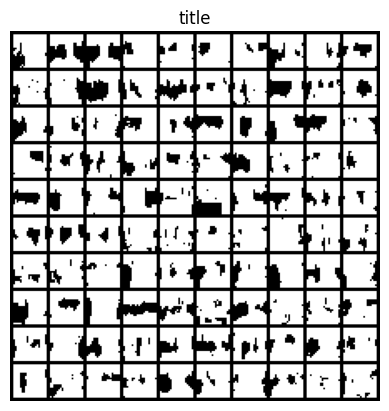

In [20]:
img_shape = (20, 20, 1)
train_losses, test_losses, samples = train_igpt(train_data, test_data, img_shape, 1)
samples = samples.astype("float32") / 1 * 255

print(f"Final Test Loss: {test_losses[-1]:.4f}")

show_sample(samples)